# Imports

In [1]:
# Make modules available
import sys
sys.path.insert(1, "./modules")

# General imports
import os
import cv2
import torch
import numpy as np
from scipy import ndimage
from importlib import reload
from torch.utils.data import DataLoader, random_split

# Import modules
from model import *
from dataset import *
from utils import *

# Set random seed 
torch.manual_seed(24)

# Datasets

## Detection Dataset

In [2]:
batch_size = 16
batch_size_seg = 2
batch_size_det = 14

In [3]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
# Convert XML files to CSV to create dataset  (#Remember to return path again )
xml_to_csv('../../NimbRoNet2/Dataset/blob/**/*.xml', 'labels.csv')

Processed:  8737  images


In [5]:
# Create custom dataset class
dataset_dt = DetectionDataset('labels.csv')

In [7]:
# Split dataset
train_size = int(0.7 * len(dataset_dt))
test_size = int(0.15 * len(dataset_dt))
validation_size = len(dataset_dt) - (train_size + test_size)

train_dt, validation_dt, test_dt = random_split(dataset_dt, [train_size, validation_size, test_size])

In [8]:
print("Size of detection test set", len(test_dt))
print("Size of detection training set:", len(train_dt))
print("Size of detection validation set:", len(validation_dt))

Size of detection test set 1310
Size of detection training set: 6116
Size of detection validation set: 1312


In [9]:
test_loader_dt = DataLoader(test_dt, batch_size=batch_size, shuffle=True)
train_loader_dt = DataLoader(train_dt, batch_size=batch_size_det, shuffle=True)
validation_loader_dt = DataLoader(validation_dt, batch_size=batch_size, shuffle=True)

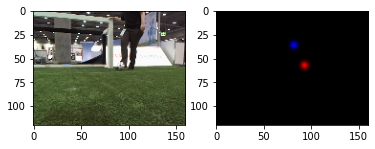

In [10]:
# Display first training image
for images, targets in train_loader_dt:
    show_image_and_probmap(downsample(images)[0], downsample(targets)[0])
    break

## Segmentation Dataset

In [11]:
# Create custom dataset
dataset_seg = SegmentationDataset('../../NimbRoNet2/Dataset/segmentation') # or define the w, and the h

In [12]:
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [13]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [14]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


In [15]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=batch_size, shuffle=True)
train_loader_seg = DataLoader(train_seg, batch_size=batch_size_seg, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=batch_size, shuffle=True)

Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


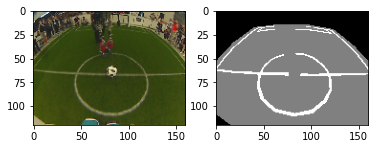

In [16]:
# Display first training image
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(downsample(image)[0], downsample(target)[0])
    break

# Train (Resnet-18 Backbone)

In [16]:
# Model
model = Model(device,160,128)
model = to_device(model, device)

In [17]:
# Set model to training mode
model.train()
print("Model ready for training...")

Model ready for training...


In [18]:
# Training parameters
epochs = 150
learning_rate = 0.1
optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), learning_rate, weight_decay=0.001)
optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), learning_rate, weight_decay=0.001)
scheduler_encoder = torch.optim.lr_scheduler.CyclicLR(optimizer_encoder,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)
scheduler_decoder = torch.optim.lr_scheduler.CyclicLR(optimizer_decoder,cycle_momentum=False,base_lr=1e-4,max_lr=1e-3,step_size_up=2000)

In [19]:
# Current iteration
iterations = 0

In [20]:
# Resolution change flags
set_resolution50 = False
set_resolution100 = False
set_resolution150 = False

In [21]:
# Losses
detection_loss_batch = []
segmentation_loss_batch = []

In [22]:
for epoch in range(epochs):
    print(f"Epoch {epoch} of {epochs}")
    # Segmentation and detection
    # cumulative losses
    cum_loss_seg = 0
    cum_loss_det = 0
    
    # Save model every 25 epochs
    if (epoch % 25 == 0 or epoch==149):
        torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/model_sot_{epoch}.pt")
    
    if epoch < 50 and not set_resolution50:
        set_resolution50 = True
        
        # Freeze encoder layers
        model.freeze_encoder()
        
        # Set resolution to quarter of orignal size
        dataset_dt.set_resolution(128,160)
        dataset_seg.set_resolution(128,160)
    elif 50 <= epoch < 100 and not set_resolution100:
        # Unfroze encoder layers
        model.unfreeze_encoder()
        
        # Set resolution to half original size
        dataset_dt.set_resolution(256,320)
        dataset_seg.set_resolution(256,320)
        
        set_resolution100 = True
    elif 100 <= epoch < 150 and not set_resolution150:
        # Set resolution to original size
        dataset_dt.set_resolution(480,640)
        dataset_seg.set_resolution(480,640)
        
        set_resolution150 = True        
    
    # Training loop
    for batch_idx in range(len(train_dt)//batch_size_det):
        # Clear gradients
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        # Segmentation batch
        batch = next(iter(train_loader_seg))
        batch = to_device(batch,device)
         
        # Segmentation forward step
        loss_seg = model.training_step_segmentation(batch) * 200
        cum_loss_seg += loss_seg.item()/len(batch[0])
        
        # Detection batch
        batch = next(iter(train_loader_dt))
        batch = to_device(batch,device)
        
        # Detection forward step
        loss_det = model.training_step_detection(batch)
        cum_loss_det += loss_det.item()/len(batch[0])
        
        # Cumulative loss
        loss = loss_det + loss_seg

        # Compute gradient
        loss.backward()

        # Backprop
        optimizer_encoder.step()
        optimizer_decoder.step()
        scheduler_encoder.step()
        scheduler_decoder.step()
    
    # Keep track of batch losses
    detection_loss_batch.append(cum_loss_det)
    segmentation_loss_batch.append(cum_loss_seg)
    
    if (epoch % 25 == 0 or epoch==149):
        # Validation for segmentation
        accuracy,iou = model.validation_segmentation(validation_loader_seg)
        print('SEGMENTATION -> Epoch: {}. Validation Accuracy: {}.  Validation IOU: {}\n'.format(epoch, accuracy['Total'],iou['Total']))

        # Validation for detection
        total_f1, total_accuracy, total_recall, total_precision, total_fdr = model.validation_detection(validation_loader_dt)
        print('DETECTION -> Epoch: {}. Validation Accuracy: {}. Validation Precision: {}. Validation Recall: {}\n'.format(epoch, 
                                                                                                                    total_accuracy, 
                                                                                                                    total_precision,
                                                                                                                    total_recall))
torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/model_sot_150.pt")

Epoch 0 of 150
Accuracy {'Field': 44.19968070406096, 'Lines': 43.46967232163607, 'Background': 43.43748280983553, 'Total': 43.931857638888886}
IOU {'Field': 0.38108126865153724, 'Lines': 0.04931842750547104, 'Background': 0.2850233263249082, 'Total': 0.23847434082730548}
SEGMENTATION -> Epoch: 0. Validation Accuracy: 43.931857638888886.  Validation IOU: 0.23847434082730548

Ball    	Recall:0.948
		Precision:0.245
		Accuracy: 0.242
		F1 Score:0.389
		FDR:0.755
Robot    	Recall:0.871
		Precision:0.178
		Accuracy: 0.173
		F1 Score:0.295
		FDR:0.822
Goal Post    	Recall:0.903
		Precision:0.219
		Accuracy: 0.214
		F1 Score:0.352
		FDR:0.781
DETECTION -> Epoch: 0. Validation Accuracy: 0.2095381889517477. Validation Precision: 0.2138177469185358. Validation Recall: 0.9072658225884033

Epoch 1 of 150
Epoch 2 of 150
Epoch 3 of 150
Epoch 4 of 150
Epoch 5 of 150
Epoch 6 of 150
Epoch 7 of 150
Epoch 8 of 150
Epoch 9 of 150
Epoch 10 of 150
Epoch 11 of 150
Epoch 12 of 150
Epoch 13 of 150
Epoch 14 of 

# Loss Plots

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

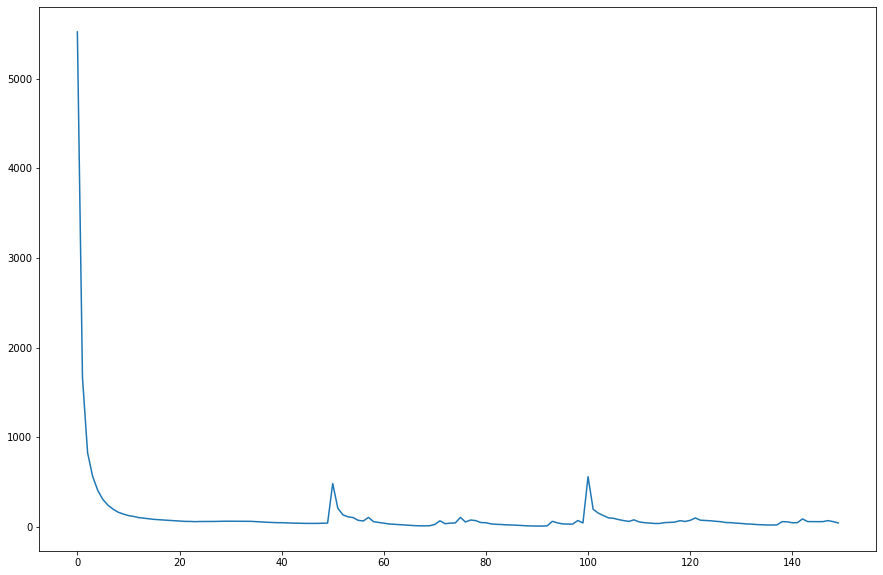

In [27]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(detection_loss_batch))
plt.show()

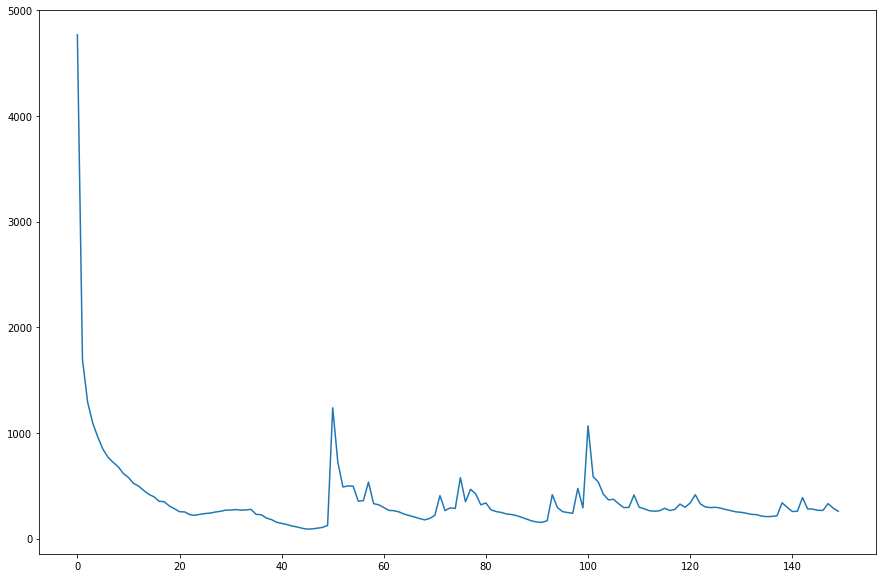

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(segmentation_loss_batch))
plt.show()

# Train (EfficientNet-B0 Backbone)

In [16]:
# Model
model = EfficientNetB0Model(device,160,128)
model = to_device(model, device)

In [17]:
# Set model to training mode
model.train()
print("Model ready for training...")

Model ready for training...


In [18]:
# Training parameters
epochs = 150
learning_rate = 0.1
optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), learning_rate, weight_decay=0.001)
optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), learning_rate, weight_decay=0.001)
scheduler_encoder = torch.optim.lr_scheduler.CyclicLR(optimizer_encoder,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)
scheduler_decoder = torch.optim.lr_scheduler.CyclicLR(optimizer_decoder,cycle_momentum=False,base_lr=1e-4,max_lr=1e-3,step_size_up=2000)

In [19]:
# Current iteration
iterations = 0

In [20]:
# Resolution change flags
set_resolution50 = False
set_resolution100 = False
set_resolution150 = False

In [21]:
# Losses
detection_loss_batch = []
segmentation_loss_batch = []

In [17]:
for epoch in range(epochs):
    print(f"Epoch {epoch} of {epochs}")
    # Segmentation and detection
    # cumulative losses
    cum_loss_seg = 0
    cum_loss_det = 0
    
    # Save model every 25 epochs
    if (epoch % 25 == 0 or epoch==149):
        torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/model_sot_{epoch}.pt")
    
    if epoch < 50 and not set_resolution50:
        set_resolution50 = True
        
        # Freeze encoder layers
        model.freeze_encoder()
        
        # Set resolution to quarter of orignal size
        dataset_dt.set_resolution(128,160)
        dataset_seg.set_resolution(128,160)
    elif 50 <= epoch < 100 and not set_resolution100:        
        # Set resolution to half original size
        dataset_dt.set_resolution(256,320)
        dataset_seg.set_resolution(256,320)
        
        set_resolution100 = True
    elif 100 <= epoch < 150 and not set_resolution150:
        # Set resolution to original size
        dataset_dt.set_resolution(480,640)
        dataset_seg.set_resolution(480,640)
        
        set_resolution150 = True        
    
    # Training loop
    for batch_idx in range(len(train_dt)//batch_size_det):
        # Clear gradients
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        # Segmentation batch
        batch = next(iter(train_loader_seg))
        batch = to_device(batch,device)
         
        # Segmentation forward step
        loss_seg = model.training_step_segmentation(batch) * 200
        cum_loss_seg += loss_seg.item()/len(batch[0])
        
        # Detection batch
        batch = next(iter(train_loader_dt))
        batch = to_device(batch,device)
        
        # Detection forward step
        loss_det = model.training_step_detection(batch)
        cum_loss_det += loss_det.item()/len(batch[0])
        
        # Cumulative loss
        loss = loss_det + loss_seg

        # Compute gradient
        loss.backward()

        # Backprop
        optimizer_encoder.step()
        optimizer_decoder.step()
        scheduler_encoder.step()
        scheduler_decoder.step()
    
    # Keep track of batch losses
    detection_loss_batch.append(cum_loss_det)
    segmentation_loss_batch.append(cum_loss_seg)
    
    if (epoch % 25 == 0 or epoch==149):
        # Validation for segmentation
        accuracy,iou = model.validation_segmentation(validation_loader_seg)
        print('SEGMENTATION -> Epoch: {}. Validation Accuracy: {}.  Validation IOU: {}\n'.format(epoch, accuracy['Total'],iou['Total']))

        # Validation for detection
        total_f1, total_accuracy, total_recall, total_precision, total_fdr = model.validation_detection(validation_loader_dt)
        print('DETECTION -> Epoch: {}. Validation Accuracy: {}. Validation Precision: {}. Validation Recall: {}\n'.format(epoch, 
                                                                                                                    total_accuracy, 
                                                                                                                    total_precision,
                                                                                                                    total_recall))

Loaded pretrained weights for efficientnet-b0
Epoch 0 of 150
Accuracy {'Field': 29.208010860285782, 'Lines': 27.3997296079315, 'Background': 30.359459665725407, 'Total': 29.531249999999996}
IOU {'Field': 0.23597519264146358, 'Lines': 0.028364823886167484, 'Background': 0.183406717536135, 'Total': 0.1492489113545887}
SEGMENTATION -> Epoch: 0. Validation Accuracy: 29.531249999999996.  Validation IOU: 0.1492489113545887

Ball    	Recall:0.939
		Precision:0.224
		Accuracy: 0.221
		F1 Score:0.361
		FDR:0.776
Robot    	Recall:0.856
		Precision:0.205
		Accuracy: 0.198
		F1 Score:0.331
		FDR:0.795
Goal Post    	Recall:0.934
		Precision:0.218
		Accuracy: 0.214
		F1 Score:0.353
		FDR:0.782
DETECTION -> Epoch: 0. Validation Accuracy: 0.21104084459766045. Validation Precision: 0.215500304797106. Validation Recall: 0.9094426620494148

Epoch 1 of 150
Epoch 2 of 150
Epoch 3 of 150
Epoch 4 of 150
Epoch 5 of 150
Epoch 6 of 150
Epoch 7 of 150
Epoch 8 of 150
Epoch 9 of 150
Epoch 10 of 150
Epoch 11 of 150